In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Aim: cluster samples by haplotypes using the Affinity Propagation algorithm

### Work

### Results:

### Conclusion:


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation

In [24]:
def get_target_region(by_windowd_db, chromosome, down_region, up_region, function=None, power_n=2):
    
    if function is not None:
        function_name = function.__name__
    function_name = "None"
    
    in_db = by_windowd_db
    target_region_df = in_db[\
                             (in_db['window'] >= down_region) & \
                             (in_db['window'] <= up_region) & \
                             (in_db['seqname'].str.contains(chromosome))\
                            ]
    header = target_region_df[['seqname','window']]
    df_values = target_region_df.iloc[:, 2:]
    
    if function_name == 'power':
        power_n = power_n        
        np_values = function(df_values, power_n)
        final_df = pd.concat([header, np_values], axis=1)
    
    elif function is not None:
        np_values = function(df_values).replace(-np.inf, 0)
        final_df = pd.concat([header, np_values], axis=1)
    else:
        final_df = target_region_df
        
    return final_df

def sort_by_variation_count(by_windows_db):
    p_table = pd.pivot_table(by_windows_db, values=by_windows_db.columns[2:], index=['window'])
    t_sum = p_table.sum()
    p_table_sorted = p_table[t_sum.sort_values(ascending=True).index]
    return p_table_sorted


def get_culstermap(data, annotate=False):
    if annotate == True:
        out_clustermap = sns.clustermap(data, vmin=0,\
                                        row_cluster = False,\
                                        figsize=(28, 10),\
                                        cbar_pos=(0, .2, .02, .4),\
                                        dendrogram_ratio=(.1, .2),\
                                        annot=True,\
                                        annot_kws={"size": 8, 'rotation': 90})
    else:
        out_clustermap = sns.clustermap(data, vmin=0,\
                                        row_cluster = False,\
                                        figsize=(28, 10),\
                                        cbar_pos=(0, .2, .02, .4),\
                                        dendrogram_ratio=(.1, .2))
        
    return out_clustermap


def drop_references(df, list_of_ref):
    for ref_i in list_of_ref:
        i = df[(df.ref == ref_i)].index
        df = df.drop(i)
    return df


def target_genes(pangenome_gene_file, gene, reference_codes):
    
    synteny_genes = pd.read_csv(pangenome_gene_file, delimiter='\t')
    synteny_genes_ = synteny_genes['chr'].str.split('__', expand=True)[1]
    synteny_genes['ref'] = synteny_genes_.map(reference_codes)
    synteny_genes['chr'] = synteny_genes['chr'].str.split('_', expand=True)[0]
    target_genes_ = synteny_genes[(synteny_genes['srcmodel'].str.contains(gene))]
    return target_genes_

In [25]:
synteny_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/04_haplotype_grouping/09_gene_synteny'
data_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/04_haplotype_grouping/00_data'

In [26]:
reference_codes = {\
'ari': 'Arina',
'jag':'Jagger',
'sta':'Stanley',
'jul':'Julius',
'lac':'Lancer',
'ldm':'Landmark',
'mac':'Mace',
'nor':'Norin61',
'sym':'Mattis',
'chi':'CS',
'tsp':'Spelt',
'ash':'Ashsyn'}

In [27]:
gene_ = 'TraesCS4B02G043100'

matched_gene = target_genes(synteny_path+'/pangenome_gene_synteny.tsv', gene_, reference_codes)
matched_gene

,chr,start,end,ID,srcmodel,ref
59313,chr4B,31493774,31495639,TraesARI4B01G047200,TraesCS4B02G043100.1,Arina
180189,chr4B,32056262,32058127,TraesJAG4B01G045500,TraesCS4B02G043100.1,Jagger
299661,chr4B,30816818,30818683,TraesSTA4B01G044300,TraesCS4B02G043100.1,Stanley
419236,chr4B,30632689,30634554,TraesJUL4B01G046900,TraesCS4B02G043100.1,Julius
537600,chr4B,30638580,30640445,TraesLAC4B01G047100,TraesCS4B02G043100.1,Lancer
658178,chr4B,32253684,32255549,TraesLDM4B01G048800,TraesCS4B02G043100.1,Landmark
776879,chr4B,30805257,30807122,TraesMAC4B01G048000,TraesCS4B02G043100.1,Mace
897308,chr4B,31408404,31410269,TraesNOR4B01G049000,TraesCS4B02G043100.1,Norin61
1015429,chr4B,30449632,30451497,TraesSYM4B01G047400,TraesCS4B02G043100.1,Mattis
1137663,chr4B,30861382,30863247,TraesCHI4B01G048000,TraesCS4B02G043100,CS


In [7]:
window = 100000
# buffer = 600000

function = np.sqrt
power_n = 0.43

if function is None:
    function_name = "None"
else:
    function_name = function.__name__

# remove references from the analysis
list_of_ref = ['Ashsyn','CS']    
matched_gene = drop_references(matched_gene, list_of_ref)
references = matched_gene['ref'].to_list()

# drop query_samples
list_of_query = ['WATDE0039', 'Santiago-pr', 'Claire-skm']

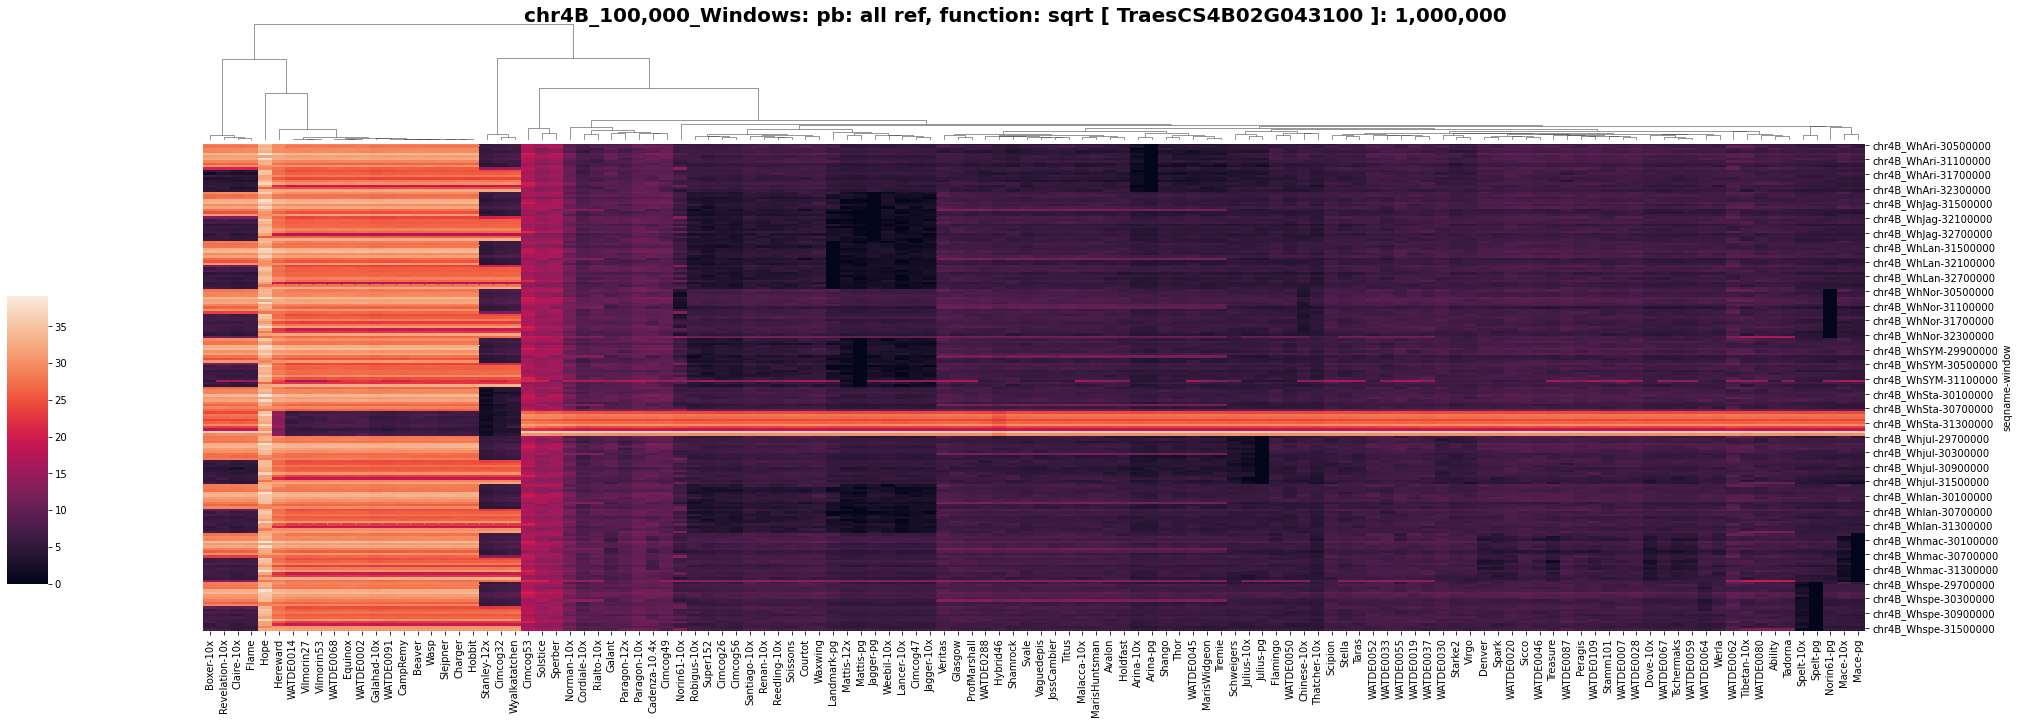

In [104]:
# combine dataframes from multiple references

buffers = [1000000]

for buffer in buffers:
    dfs = []
    for reference in references:

        gene_position = int(matched_gene[matched_gene['ref'] == reference]['start'].values)
        chromosome = matched_gene[matched_gene['ref'] == reference]['chr'].values[0]
        down_region = gene_position - buffer
        up_region = gene_position + buffer
        file_db = pd.read_csv(f'{data_path}/{reference}_vs_all_variations_{window}_windows.tsv', delimiter='\t')

        # drop outlier samples
        file_db = file_db.drop(list_of_query, axis=1, errors='ignore')

        # find and extract gene region
        get_target_region_ = get_target_region(file_db, chromosome, down_region, up_region, function, power_n)

        dfs.append(get_target_region_)

    dfs_concat = pd.concat(dfs, join="inner")

    heatmap_data = pd.pivot_table(dfs_concat, values=dfs_concat.columns, index=['seqname', 'window'])
    get_culstermap_ = get_culstermap(heatmap_data).fig.suptitle(f'{chromosome}_{window:,}_Windows: pb: all ref, function: {function_name} [ {gene_} ]: {buffer:,}', fontsize=20, va="baseline", weight="bold")
plt.savefig(f'rht_clustermap_all_references_sqrt.jpg', dpi=150, bbox_inches='tight')


## Transpose data

In [9]:
# dfs_concat = dfs_concat.iloc[:20, :]
# dfs_concat

In [96]:
dfs_concat_ = dfs_concat.set_index(['seqname', 'window']).T
# dfs_concat_

## Data to an array  and index as labels

In [97]:
X  = dfs_concat_.to_numpy()
Y = dfs_concat_.index
X.shape

(120, 200)

In [98]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [99]:
damping_ = [0.5,0.6,0.7,0.8,0.9]

In [100]:
dfs_ = []
for damping in damping_:
    
    af = AffinityPropagation(random_state=0, damping=damping).fit(X)
    X_predicted = af.fit_predict(X)
    dfs_concat_.insert(loc=0,  column=f'damp_{damping}', value=X_predicted, allow_duplicates=True)


In [101]:
dfs_concat_

seqname       damp_0.9 damp_0.8 damp_0.7 damp_0.6 damp_0.5 chr4B_WhAri  \
window                                                        30500000   
Galahad-10x          0       12       12       12       12   29.189039   
Norin61-10x          0       10       10       10       10    4.898979   
Norman-10x           0        0        0        0        0    8.774964   
Cimcog49             0        0        0        0        0    8.774964   
Spelt-10x            0       11       11       11       11    4.582576   
...                ...      ...      ...      ...      ...         ...   
WATDE0087            0       10       10       10       10    5.830952   
WATDE0091            0       12       12       12       12   29.137605   
WATDE0109            0       10       10       10       10    6.082763   
WATDE0288            0        9        9        9        2    4.123106   
Wyalkatatchen        0        2        2        2        3    6.708204   

seqname                                                    ... chr4B_Whspe  \
window          30600000   30700000   30800000   30900000  ...    30700000   
Galahad-10x    27.568098  29.427878  29.034462  33.778692  ...   24.454039   
Norin61-10x     6.708204   6.855655   6.403124   8.306624  ...   10.440307   
Norman-10x      8.944272  10.344080   8.366600  11.832160  ...   11.401754   
Cimcog49       10.535654  10.000000  10.246951  12.083046  ...    9.539392   
Spelt-10x       5.830952   6.855655   6.633250   7.483315  ...    2.236068   
...                  ...        ...        ...        ...  ...         ...   
WATDE0087       7.874008   8.185353   7.416198   9.539392  ...    8.366600   
WATDE0091      27.946377  29.240383  29.512709  34.073450  ...   24.310492   
WATDE0109       8.185353   7.874008   7.745967   8.888194  ...    7.483315   
WATDE0288       6.633250   5.830952   3.605551   6.082763  ...    6.708204   
Wyalkatatchen   6.633250   6.708204   6.000000   7.211103  ...   23.323808   

seqname                                                               \
window          30800000   30900000   31000000   31100000   31200000   
Galahad-10x    25.357445  27.276363  25.377155  26.191602  30.724583   
Norin61-10x     6.000000   7.071068   6.633250   9.327379   6.000000   
Norman-10x     12.489996  11.135529   9.899495  11.747340  13.453624   
Cimcog49        9.848858  10.583005   8.717798  10.723805   9.486833   
Spelt-10x       3.000000   2.236068   1.732051   2.645751   3.605551   
...                  ...        ...        ...        ...        ...   
WATDE0087       6.708204   7.874008   7.000000   7.416198   7.745967   
WATDE0091      25.632011  27.294688  25.592968  26.683328  30.577770   
WATDE0109       7.141428   6.928203   5.291503   6.403124   8.544004   
WATDE0288       6.557439   7.141428   6.633250   7.810250   8.124038   
Wyalkatatchen  25.884358  27.531800  25.455844  26.570661  31.000000   

seqname                                                    
window          31300000   31400000   31500000   31600000  
Galahad-10x    23.065125  18.947295  30.692019  30.675723  
Norin61-10x    11.000000   5.744563   6.244998  13.190906  
Norman-10x     12.165525   9.643651  11.269428  10.816654  
Cimcog49        9.643651   7.745967   9.055385   7.874008  
Spelt-10x       3.000000   1.414214   3.162278   1.000000  
...                  ...        ...        ...        ...  
WATDE0087       8.660254   6.708204   6.000000   8.485281  
WATDE0091      22.912878  19.390719  30.740852  30.822070  
WATDE0109       6.708204   6.480741   6.082763   7.141428  
WATDE0288       6.324555   6.557439   6.403124   6.000000  
Wyalkatatchen  23.259407  19.416488  30.903074  31.432467  

[120 rows x 205 columns]

In [103]:
dfs_concat_.to_csv("affinity_damping.tsv", sep = "\t", index=True)

In [16]:
af.cluster_centers_indices_

array([3])

In [17]:
af.cluster_centers_.shape


(1, 200)

In [18]:
af.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
af.n_iter_

16

In [20]:
affinity_matrix_save = pd.DataFrame(af.affinity_matrix_)

In [21]:
affinity_matrix_save.to_csv("affinity_matrix_.tsv", sep = "\t", index=True)

In [105]:
# dfs_concat_.insert(loc=0,  column='group', value=damping_dfs)
# dfs_concat_.to_csv("affinity_scaler.tsv", sep = "\t", index=True)